In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression as lm
#from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

### First, let's make future graphs prettie

In [2]:
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

### Then, read our data

In [3]:
data = pd.read_csv('C:\\Users\\Inna\\Documents\\0.DataScienceSchool\\FirstKernel_LinearReg\\insurance.csv')

### And make a quick glance on it: 

In [4]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Then let's explore some basic information about the data and its statistics:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


In [6]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
print('The list of the features:', list(data.columns))

The list of the features: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


In [8]:
# Checking missing values
missingV = data.isnull().sum()
missingV.percent = missingV/len(data)*100
missingV.percent

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

# Quick first impression and data summary: 

##### * Small dataset comprised of only 1338 entries
##### * But, hallelujah, no missing values!

# Objectives: we are going to predict insurance charges by given the information about age, sex, bmi, number of children, smoking and a residence (region) of the people

# 1. First, let's do some preprocessing

#### "Age", "bmi" and "charges" are continuous numerical variables. Thus, we can look into their distributions: 

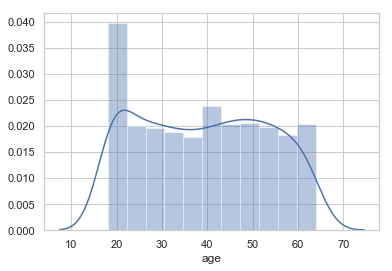

In [9]:
sns.distplot(data['age'])

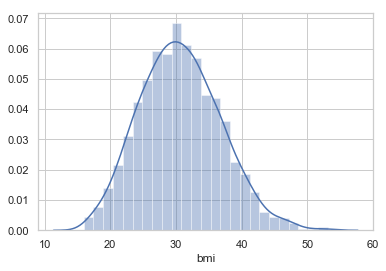

In [10]:
sns.distplot(data['bmi'])

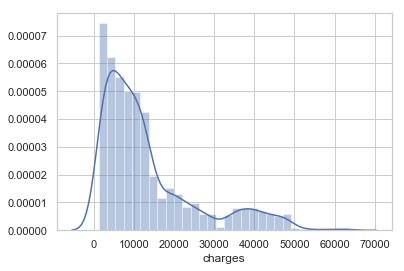

In [11]:
sns.distplot(data['charges'])

#### "Children" is not a continuous variable (you can't have 1.5 child, obviously), but it's an ordinal variable, so we can look into its distribution:
##### * More about data scales here: https://www.datacamp.com/community/tutorials/categorical-data

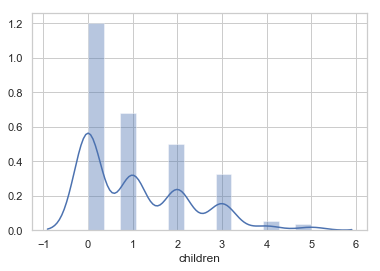

In [12]:
sns.distplot(data['children'])

#### Now let's handle categorical, non-numerical, variables such as "sex", "smoker" and "region". We will convert them into so a format that machine learning models can process them

#### We are going to encode two-levels variables "sex" and "smoker", and create a one-hot vectors for the "region" variable, and also create an additional variable "north" that will receive 1 for any northeren region and 0 for any southeren region

In [13]:
# Create new columns that represent categorical data in the DataFrame
data['sex_num'] = data.sex.map({'female':1, 'male':0})
data['smoke_num'] = data.smoker.map({'yes':1, 'no':0})
# Add region north or south (1 for the north)
data['north'] = data['region'].apply(lambda x: 1 if (x == 'northwest' or x == 'northeast') else 0)

##### * Note that "female" is encoded as "1" and "male" as "2"

In [14]:
# One-hot vectors for different regions: 
# 1. create vectors of zeros: 
data_len = len(data['region'])
data['southwest'] = pd.Series(np.zeros(data_len), index = data.index)
data['southeast'] = pd.Series(np.zeros(data_len), index = data.index)
data['northwest'] = pd.Series(np.zeros(data_len), index = data.index)
data['northeast'] = pd.Series(np.zeros(data_len), index = data.index)

# 2. encode the data into these vectors acording to the regions: 
data['southwest'] = data['southwest'].where(data['region'] != 'southwest', 1)
data['southeast'] = data['southeast'].where(data['region'] != 'southeast', 1)
data['northwest'] = data['northwest'].where(data['region'] != 'northwest', 1)
data['northeast'] = data['northeast'].where(data['region'] != 'northeast', 1)

#### Let's look at our data again: 

In [15]:
data.head()

,age,sex,bmi,children,smoker,region,charges,sex_num,smoke_num,north,southwest,southeast,northwest,northeast
0,19,female,27.900,0,yes,southwest,16884.92400,1,1,0,1.0,0.0,0.0,0.0
1,18,male,33.770,1,no,southeast,1725.55230,0,0,0,0.0,1.0,0.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,0,0,0.0,1.0,0.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,0,1,0.0,0.0,1.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,0,1,0.0,0.0,1.0,0.0


##### Note that six new columns that represent categorical variable were added to the data matrix

# 2. Second, let's explore relationships between the variables

#### We will start from calculating correlations between them: 

In [16]:
corrs = data.corr()
corrs

,age,bmi,children,charges,sex_num,smoke_num,north,southwest,southeast,northwest,northeast
age,1.000000,0.109272,0.042469,0.299008,0.020856,-0.025019,0.001772,0.010016,-0.011642,-0.000407,0.002475
bmi,0.109272,1.000000,0.012759,0.198341,-0.046371,0.003750,-0.235113,-0.006205,0.270025,-0.135996,-0.138156
children,0.042469,0.012759,1.000000,0.067998,-0.017163,0.007673,0.001735,0.021914,-0.023066,0.024806,-0.022808
charges,0.299008,0.198341,0.067998,1.000000,-0.057292,0.787251,-0.028799,-0.043210,0.073982,-0.039905,0.006349
sex_num,0.020856,-0.046371,-0.017163,-0.057292,1.000000,-0.076185,0.011651,0.004184,-0.017117,0.011156,0.002425
smoke_num,-0.025019,0.003750,0.007673,0.787251,-0.076185,1.000000,-0.029292,-0.036945,0.068498,-0.036945,0.002811
north,0.001772,-0.235113,0.001735,-0.028799,0.011651,-0.029292,1.000000,-0.549730,-0.593313,0.583612,0.582426
southwest,0.010016,-0.006205,0.021914,-0.043210,0.004184,-0.036945,-0.549730,1.000000,-0.346265,-0.320829,-0.320177
southeast,-0.011642,0.270025,-0.023066,0.073982,-0.017117,0.068498,-0.593313,-0.346265,1.000000,-0.346265,-0.345561
northwest,-0.000407,-0.135996,0.024806,-0.039905,0.011156,-0.036945,0.583612,-0.320829,-0.346265,1.000000,-0.320177


#### Or the same correlation results in graphical representation: 

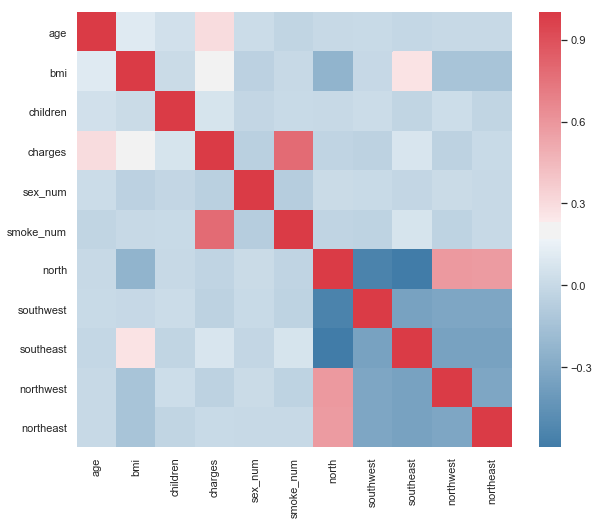

In [17]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrs, mask=np.zeros_like(corrs, dtype = np.bool), cmap = sns.diverging_palette(240, 10, as_cmap = True),
            square = True, ax = ax)

### Findings:  the predicted variable, "charges", is correlated with the following features: 
#### 1. Age
#### 2. bmi
#### 3. smoker

# 3. Third, let's perform in-depth analisys of the most interesting predictiors

## (1) EXPLORE WEIGHT

In [18]:
data.bmi.describe()

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64

#### We alread saw that bmi has bell shaped normal distribution with a mean of 30.7 and std of 6.1

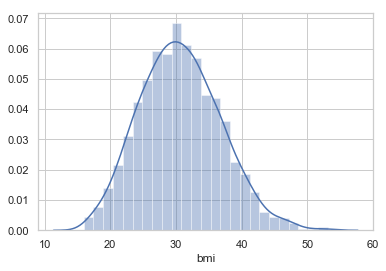

In [19]:
sns.distplot(data['bmi'])

#### According to Wikipedia, obesity is defined by BMI scores larger than 30, whereas underweight is defined by scores smaller than 18.5

In [20]:
data['obesity'] = pd.Series(np.zeros(data_len), index = data.index)
data['obesity'] = data['obesity'].mask(data['bmi'] > 30, 1)
data['underweight'] = pd.Series(np.zeros(data_len), index = data.index)
data['underweight'] = data['underweight'].mask(data['bmi'] < 18.5, 1)

In [21]:
data.head()

,age,sex,bmi,children,smoker,region,charges,sex_num,smoke_num,north,southwest,southeast,northwest,northeast,obesity,underweight
0,19,female,27.900,0,yes,southwest,16884.92400,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0
1,18,male,33.770,1,no,southeast,1725.55230,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
print('Total number of obese people =', data.obesity.sum() )
print('Total number of underweight people =', data.underweight.sum() )

Total number of obese people = 705.0
Total number of underweight people = 20.0


#### Since the number of underweight people is very small (approximately 5% of the total population in the dataset), we can't make any meangful conclusions based on such a small sample (N = 20). Thus, we will concentrate on the obese subgroup only

In [23]:
# Delete "underweight" column: 
data.drop(['underweight'], axis=1, inplace = True)

#### Let's look on the two groups (obese and non-obese) distributions and their relationships to other variables

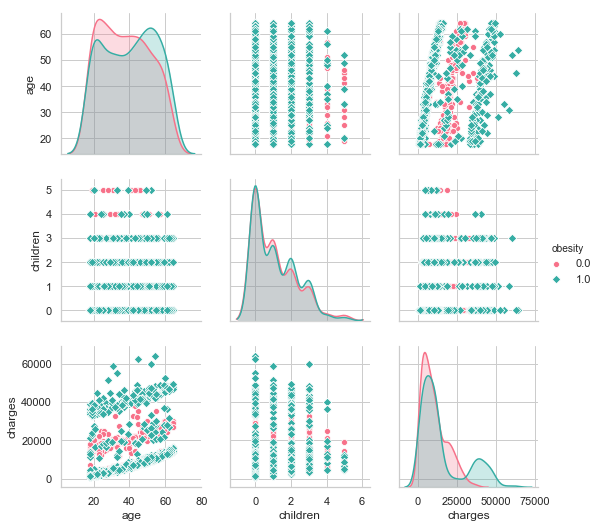

In [24]:
g = sns.pairplot(data, vars=['age', 'children', 'charges'], hue="obesity", markers=["o", "D"], palette="husl")

#### In general, obese people pay more. But interestingly, young obese people pay less, whereas old obese people pay more than non-obese. Moreover, there is a subgroup of obese people who has especially large medical spendings. This small subgroup of obese people is responsible for most of the large charges. Let's define and explore them

In [25]:
data['obesity_high_charges'] = pd.Series(np.zeros(data_len), index = data.index)
data['obesity_high_charges'] = data.obesity_high_charges.where(data.charges > 30000)
data_subgroup1 = data.dropna(how='any')

#### Now we can compare these two groups: (1) general population, and (2) subgroup of obese people who also pay extremely large medical bills. (* Note that not all obese people have pay more)

In [26]:
data_subgroup1.head()

,age,sex,bmi,children,smoker,region,charges,sex_num,smoke_num,north,southwest,southeast,northwest,northeast,obesity,obesity_high_charges
14,27,male,42.13,0,yes,southeast,39611.7577,0,1,0,0.0,1.0,0.0,0.0,1.0,0.0
19,30,male,35.30,0,yes,southwest,36837.4670,0,1,0,1.0,0.0,0.0,0.0,1.0,0.0
23,34,female,31.92,1,yes,northeast,37701.8768,1,1,1,0.0,0.0,0.0,1.0,1.0,0.0
29,31,male,36.30,2,yes,southwest,38711.0000,0,1,0,1.0,0.0,0.0,0.0,1.0,0.0
30,22,male,35.60,0,yes,southwest,35585.5760,0,1,0,1.0,0.0,0.0,0.0,1.0,0.0


In [27]:
# Obese high paying people: 
data_subgroup1.describe()

,age,bmi,children,charges,sex_num,smoke_num,north,southwest,southeast,northwest,northeast,obesity,obesity_high_charges
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.0
mean,40.376543,34.845432,1.166667,40761.308558,0.364198,0.938272,0.395062,0.228395,0.376543,0.179012,0.216049,0.919753,0.0
std,14.472512,4.736925,1.137994,6165.955587,0.482697,0.241408,0.490380,0.421100,0.486021,0.384551,0.412824,0.272517,0.0
min,18.000000,17.765000,0.000000,30063.580550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,27.000000,31.692500,0.000000,36203.125612,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
50%,42.000000,34.650000,1.000000,39854.111650,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,52.750000,37.027500,2.000000,44481.999400,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0
max,64.000000,52.580000,4.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [28]:
# General population: 
data.describe()

,age,bmi,children,charges,sex_num,smoke_num,north,southwest,southeast,northwest,northeast,obesity,obesity_high_charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,162.0
mean,39.207025,30.663397,1.094918,13270.422265,0.494768,0.204783,0.485052,0.242900,0.272048,0.242900,0.242152,0.526906,0.0
std,14.049960,6.098187,1.205493,12110.011237,0.500160,0.403694,0.499963,0.428995,0.445181,0.428995,0.428546,0.499462,0.0
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,27.000000,26.296250,0.000000,4740.287150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,39.000000,30.400000,1.000000,9382.033000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,51.000000,34.693750,2.000000,16639.912515,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [29]:
print('Total number of obese people who has an exptrimely large medical bills is', data_subgroup1.count()[0] )

Total number of obese people who has an exptrimely large medical bills is 162


In [30]:
print('Percentage of smokers in the group of obese and high paying people is', 
      round(data_subgroup1.smoke_num.sum()/data_subgroup1.smoke_num.count()*100, 2), '%')

Percentage of smokers in the group of obese and high paying people is 93.83 %


In [31]:
print('Percentage of smokers in general population is', 
      round(data.smoke_num.sum()/data.smoke_num.count()*100, 2), '%')

Percentage of smokers in general population is 20.48 %


In [32]:
print('Percentage of women in the subgroup is equal to', 
      round(data_subgroup1.sex_num.sum()/data_subgroup1.sex_num.count()*100, 2), '%')

Percentage of women in the subgroup is equal to 36.42 %


In [33]:
print('Percentage of women in general population of the dataset is', 
      round(data.sex_num.sum()/data.sex_num.count()*100, 2), '%')

Percentage of women in general population of the dataset is 49.48 %


#### To summarize findings, the subgroup of obese people with extremely high medical bills is characterized mostly by smoking (more than 90% of them smoke!), slightly more men than women and slightly more residents of southeast than in the general population

# NOW LET'S EXPLORE RELATIONSHIPS BETWEEN AGE, OBESITY AND CHARGES... 

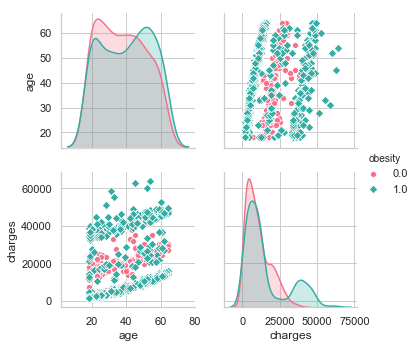

In [34]:
g = sns.pairplot(data, vars = ['age', 'charges'], hue="obesity", markers=["o", "D"], palette="husl", 
                x_vars=['age'], y_vars=['charges'])

## (2) EXPLORE SMOKING

#### The most correlated with "charges" variable was "smoke". Thus, it's worth to expore it further

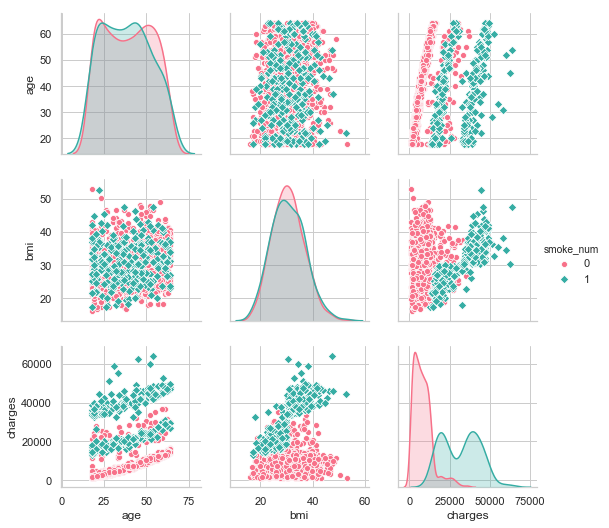

In [35]:
g = sns.pairplot(data, vars=['age', 'bmi', 'charges'], hue="smoke_num", markers=["o", "D"], palette="husl")

#### Clearly that smoking contributes to the medical costs

In [36]:
data.groupby('smoke_num').age.describe()

,count,mean,std,min,25%,50%,75%,max
smoke_num,,,,,,,,
0,1064.0,39.385338,14.083410,18.0,26.75,40.0,52.0,64.0
1,274.0,38.514599,13.923186,18.0,27.00,38.0,49.0,64.0


In [37]:
data.groupby('smoke_num').bmi.describe()

,count,mean,std,min,25%,50%,75%,max
smoke_num,,,,,,,,
0,1064.0,30.651795,6.043111,15.960,26.31500,30.3525,34.43,53.13
1,274.0,30.708449,6.318644,17.195,26.08375,30.4475,35.20,52.58


In [38]:
data.groupby('smoke_num').children.describe()

,count,mean,std,min,25%,50%,75%,max
smoke_num,,,,,,,,
0,1064.0,1.090226,1.218136,0.0,0.0,1.0,2.0,5.0
1,274.0,1.113139,1.157066,0.0,0.0,1.0,2.0,5.0


In [39]:
data.groupby('smoke_num').southwest.describe()

,count,mean,std,min,25%,50%,75%,max
smoke_num,,,,,,,,
0,1064.0,0.250940,0.433758,0.0,0.0,0.0,1.0,1.0
1,274.0,0.211679,0.409246,0.0,0.0,0.0,0.0,1.0


In [40]:
data.groupby('smoke_num').southeast.describe()

,count,mean,std,min,25%,50%,75%,max
smoke_num,,,,,,,,
0,1064.0,0.256579,0.436950,0.0,0.0,0.0,1.0,1.0
1,274.0,0.332117,0.471834,0.0,0.0,0.0,1.0,1.0


In [41]:
data.groupby('smoke_num').northwest.describe()

,count,mean,std,min,25%,50%,75%,max
smoke_num,,,,,,,,
0,1064.0,0.250940,0.433758,0.0,0.0,0.0,1.0,1.0
1,274.0,0.211679,0.409246,0.0,0.0,0.0,0.0,1.0


In [42]:
data.groupby('smoke_num').northeast.describe()

,count,mean,std,min,25%,50%,75%,max
smoke_num,,,,,,,,
0,1064.0,0.241541,0.428219,0.0,0.0,0.0,0.0,1.0
1,274.0,0.244526,0.430592,0.0,0.0,0.0,0.0,1.0


In [43]:
data.groupby('smoke_num').obesity.describe()

,count,mean,std,min,25%,50%,75%,max
smoke_num,,,,,,,,
0,1064.0,0.527256,0.499491,0.0,0.0,1.0,1.0,1.0
1,274.0,0.525547,0.500261,0.0,0.0,1.0,1.0,1.0


#### Nothing interesting here meanwhile, on average there is no difference between smokers and non-smokers

In [44]:
data.groupby('smoke_num').charges.describe()

,count,mean,std,min,25%,50%,75%,max
smoke_num,,,,,,,,
0,1064.0,8434.268298,5993.781819,1121.8739,3986.438700,7345.40530,11362.887050,36910.60803
1,274.0,32050.231832,11541.547176,12829.4551,20826.244213,34456.34845,41019.207275,63770.42801


#### But they do pay much more than people who do not smoke!

Text(0.5, 1.0, 'Charges of Smokers')

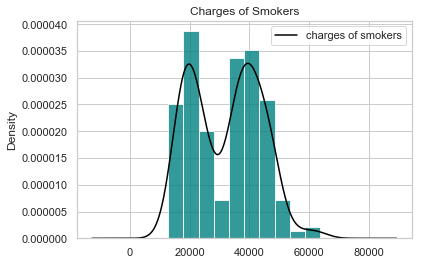

In [45]:
smokers = data.where(data.smoke_num == 1)
smokers.charges.hist(bins = 10, color = 'teal', alpha = 0.8, density = True)
smokers.charges.plot(kind='density', color='black')
plt.legend(['charges of smokers'])
plt.title('Charges of Smokers')

Text(0.5, 1.0, 'Charges of Nonsmokers')

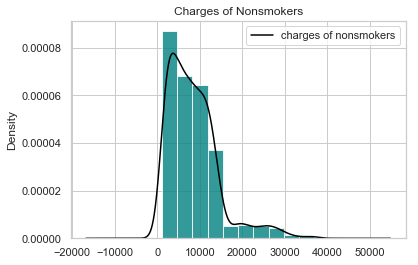

In [46]:
nonsmokers = data.where(data.smoke_num == 0)
nonsmokers.charges.hist(bins = 10, color = 'teal', alpha = 0.8, density = True)
nonsmokers.charges.plot(kind='density', color='black')
plt.legend(['charges of nonsmokers'])
plt.title('Charges of Nonsmokers')

Text(0.5, 1.0, 'Charges of Both Smokers and Nonsmokers')

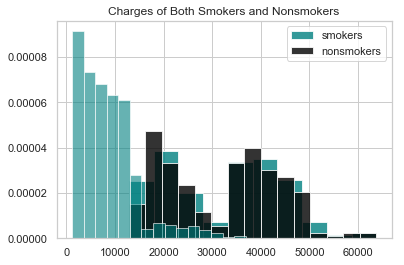

In [47]:
smokers = data.where(data.smoke_num == 1)
smokers.charges.hist(bins = 10, color = 'teal', alpha = 0.8, density = True)
nonsmokers = data.where(data.smoke_num == 0)

smokers.charges.hist(bins = 15, color = 'black', density = True, alpha = 0.8)  
nonsmokers.charges.hist(bins = 15, color='teal', alpha = 0.6, density = True)
# density: normalization to form probability density, pdf


plt.legend(['smokers', 'nonsmokers'])
plt.title('Charges of Both Smokers and Nonsmokers')

#### And the distributions of their medical costs look very different. No doubt, smoking is going to be one of the main predictors of the medical costs

## (3) EXPLORE PARENTHOOD

#### Although correlation between the number of children and medical costs are not high (app. 7%), it is correlated with other varibale. Thus, it's worth to explore the variable further. 

In [48]:
data['parent'] = pd.Series(np.zeros(data_len), index = data.index)
data['parent'] = data['parent'].where(data['children'] == 0, 1)

Text(0.5, 1.0, 'Charges of Parents')

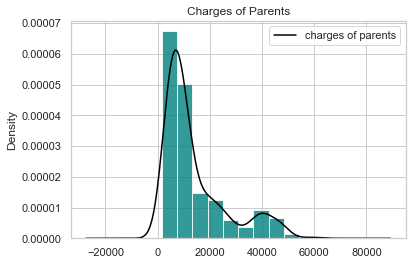

In [49]:
parent = data.where(data.parent == 1)
parent.charges.hist(bins = 10, color = 'teal', alpha = 0.8, density = True)
parent.charges.plot(kind='density', color='black')
plt.legend(['charges of parents'])
plt.title('Charges of Parents')

Text(0.5, 1.0, 'Charges of Nonparents')

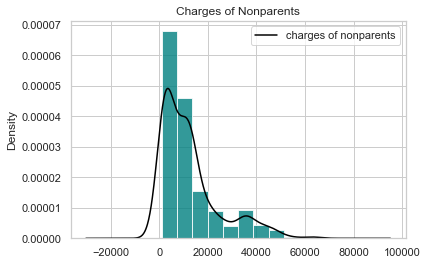

In [50]:
nonparent = data.where(data.parent == 0)
nonparent.charges.hist(bins = 10, color = 'teal', alpha = 0.8, density = True)
nonparent.charges.plot(kind='density', color='black')
plt.legend(['charges of nonparents'])
plt.title('Charges of Nonparents')

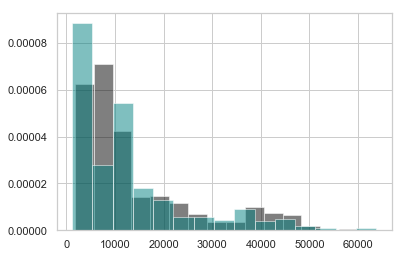

In [51]:
parent = data.where(data.parent == 1)
nonparent = data.where(data.parent == 0)

parent.charges.hist(bins = 15, color = 'black', density = True, alpha = 0.5)  
nonparent.charges.hist(bins = 15, color='teal', alpha = 0.5, density = True)  # alpha = transperancy

#### Distributions overlap in general, suggesting that there is no substantial differences in medical costs between parents and non-parents

#### Let's look on a few more graphs

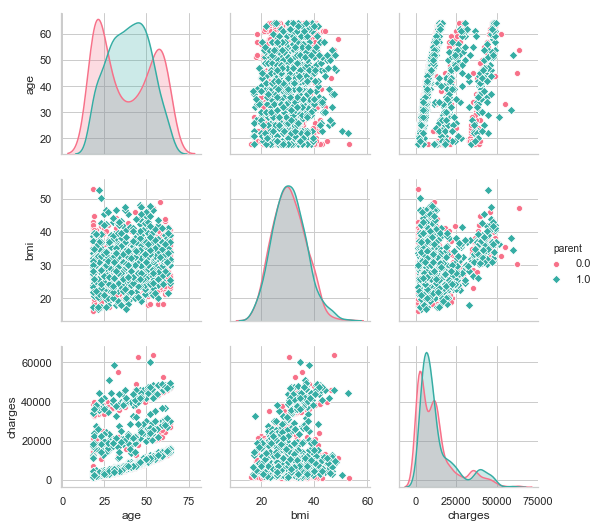

In [52]:
g = sns.pairplot(data, vars=['age', 'bmi', 'charges'], hue="parent", markers=["o", "D"], palette="husl")

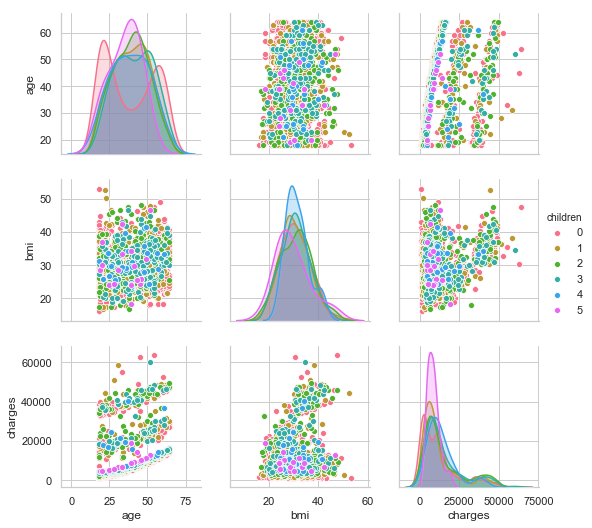

In [53]:
g = sns.pairplot(data, vars=['age', 'bmi', 'charges'], hue="children", palette="husl")

## (4) EXPLORE GENDER

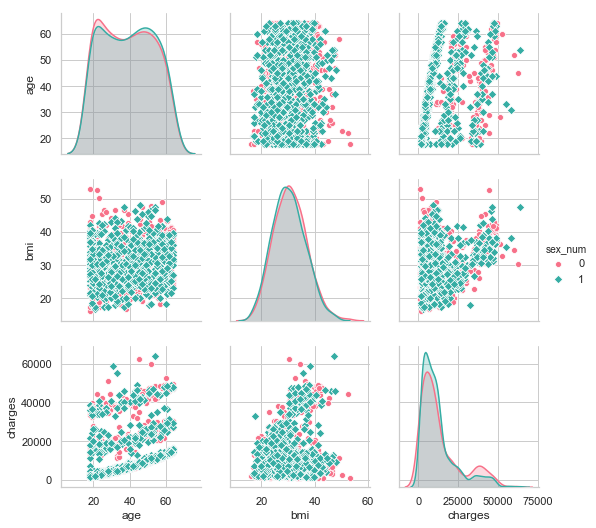

In [54]:
g = sns.pairplot(data, vars=['age', 'bmi', 'charges'], hue='sex_num', markers=["o", "D"], palette="husl")

#### No visible differences between the genders

## (4) EXPLORE RESIDENCE

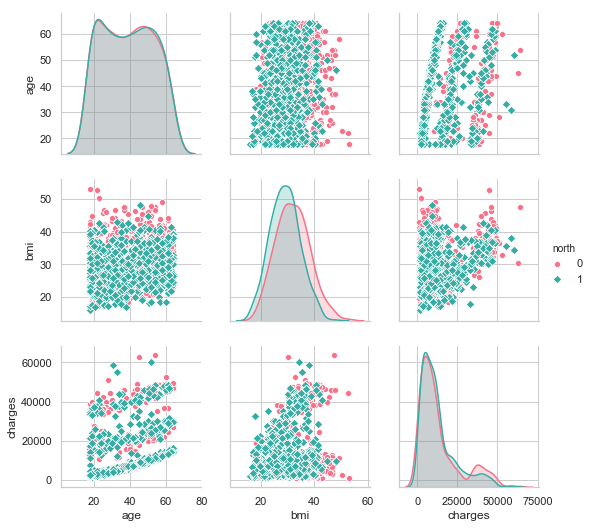

In [55]:
g = sns.pairplot(data, vars=['age', 'bmi', 'charges'], hue="north", markers=["o", "D"], palette="husl")

#### It look like northeren people are slightly lighter than southeren.

# Summary

#### 1. Smoking is highly correlated to medical costs
#### 2. Obesity also contribute to costs, but mostly when it comes with smoking
#### 3. Within the group of obese people who smoke gender and residence may play a role also

## Let's build a prediction model now and calculate how this variables predict the outcome

# PREDICTION MODELS

In [56]:
data.head()

,age,sex,bmi,children,smoker,region,charges,sex_num,smoke_num,north,southwest,southeast,northwest,northeast,obesity,obesity_high_charges,parent
0,19,female,27.900,0,yes,southwest,16884.92400,1,1,0,1.0,0.0,0.0,0.0,0.0,NaN,0.0
1,18,male,33.770,1,no,southeast,1725.55230,0,0,0,0.0,1.0,0.0,0.0,1.0,NaN,1.0
2,28,male,33.000,3,no,southeast,4449.46200,0,0,0,0.0,1.0,0.0,0.0,1.0,NaN,1.0
3,33,male,22.705,0,no,northwest,21984.47061,0,0,1,0.0,0.0,1.0,0.0,0.0,NaN,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,0,1,0.0,0.0,1.0,0.0,0.0,NaN,0.0


# Model 1 - linear reg all features

####  Let's start with the most basic model where we predict medical cost based on all variables. 

#### 1. Select features

In [57]:
X = data[['age', 'sex_num', 'bmi', 'children', 'smoke_num', 'southwest', 'southeast', 'northwest', 'northeast']]
y = data['charges']

#### 2. Split the data to two sets: one for training or fitting the model and one for testing it

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#### 3. Define the model (Linear Regression in that case) and fit an estimator to be able later to predict the charges for an unseen example

In [59]:
model = lm().fit(X_train,y_train)

#### 4. Predict y based on the model we fitted in the previous step

In [60]:
y_predicted = model.predict(X_test)

#### 5. Evaluate our model 

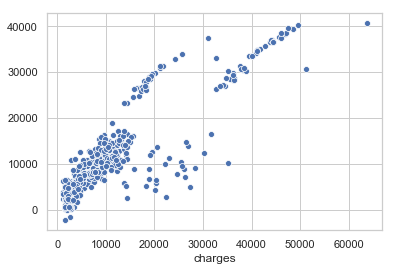

In [61]:
sns.scatterplot(y_test,y_predicted)

In [62]:
#sns.regplot(x = "y_test", y = "y_predicted", data=None) 

In [63]:
# R^2 - Bias
model.score(X_train,y_train)

0.7453768932202687

In [64]:
# R^2 - Variance
model.score(X_test,y_test)

0.7602196966782768

In [65]:
model.coef_

array([  241.27878731,   -52.13546398,   367.1887526 ,   494.29061749,
       23463.56486895,  -554.70638826,  -267.00328737,   495.76797647,
         325.94169916])

# Model 2 - linear regression, 4 features

#### Since we don't have big amount of training data, it's worth reduce dimensionality. 
#### Thus, we choose features that have a substantial correlation, positive or negative, with the predicted variable ('charges')

In [66]:
X = data[['age', 'bmi', 'children', 'smoke_num']]
y = data['charges']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 101)

In [68]:
model = lm().fit(X_train,y_train)

In [69]:
y_predicted = model.predict(X_test)

### Model Estimation

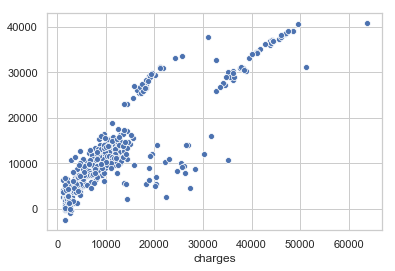

In [70]:
sns.scatterplot(y_test,y_predicted)

In [71]:
# Correlation
np.corrcoef(y_test, y_predicted)

array([[1.        , 0.87331007],
       [0.87331007, 1.        ]])

In [72]:
# Covariance
# np.cov(y_test,y_predicted)

In [73]:
# R^2 - General
model.score(X, y)

0.7489796450247748

In [74]:
# R^2 = Bias
model.score(X_train,y_train)

0.7442036941238107

In [75]:
# R^2 = Variance (generalization)
model.score(X_test,y_test)

0.7602588677269442

In [77]:
#sk.metrics.r2_score

#### The variance is higher than the bias. It means that there is no overfitting problem, the model generalizes well. --> Thus, there is no need in regularization. 

In [78]:
model.coef_

array([  241.81575872,   355.20884332,   495.13412125, 23453.63082433])

In [79]:
params = model.get_params()
params

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [80]:
# ADD GRAPH x-test vs y-test and regression line

# Model 3 - Polynomial Regression degree 2

In [81]:
X = data[['age', 'bmi', 'children', 'smoke_num']]
y = data['charges']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [83]:
model = Pipeline([('poly', PolynomialFeatures(degree = 2)),('linear', lm(fit_intercept=False))])

In [84]:
model = model.fit(X_train, y_train)

In [85]:
model.named_steps['linear'].coef_

array([-3.29102799e+03, -2.01656585e+02,  5.79715064e+02,  4.85499127e+02,
       -9.69011723e+03,  4.59133280e+00,  2.73249465e+00,  1.08863070e+01,
       -2.21448920e+01, -1.05954500e+01,  1.69444555e+00,  1.43972466e+03,
       -5.00448043e+01, -3.29695540e+02, -9.69011723e+03])

In [86]:
y_predicted = model.predict(X_test)

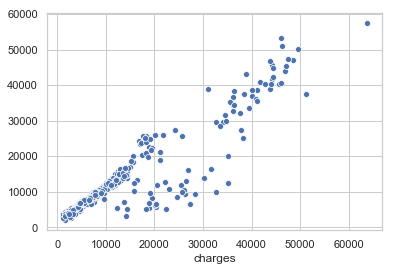

In [87]:
sns.scatterplot(y_test,y_predicted)

In [88]:
# R^2 = Bias
model.score(X_train,y_train)

0.8410355680622936

In [89]:
# R^2 = Variance (generalization)
model.score(X_test,y_test)

0.8451673509830613

#### Degree 2 provides best generalization quality (highest R^2 of the test data)

#### No need in regularization because the variance is greater than bias. Thus, the is no overfitting

# Next question I would like to explore are the following: 
# (1) Can normalization or standardization improve the outcome,
# (2) Hyper-parameters turning

# To be continued... 